In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [3]:
# Define dataset path
dataset_path = r"D:\hydralic_systems_project\dataset"  # Use raw string for Windows paths

# Check if the dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path does not exist: {dataset_path}")

# List of sensor files
sensor_files = [
    "CE.txt", "CP.txt", "EPS1.txt", "FS1.txt", "FS2.txt", "PS1.txt", "PS2.txt",
    "PS3.txt", "PS4.txt", "PS5.txt", "PS6.txt", "SE.txt", "TS1.txt", "TS2.txt",
    "TS3.txt", "TS4.txt", "VS1.txt"
]

# Read sensor data files and concatenate them
dataframes = []
for file in sensor_files:
    file_path = os.path.join(dataset_path, file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    df = pd.read_csv(file_path, header=None, delimiter=r'\s+')  # Read the file with space delimiter
    dataframes.append(df)

# Concatenate all dataframes along columns
df = pd.concat(dataframes, axis=1)

# Load target data
profile_path = os.path.join(dataset_path, "profile.txt")
if not os.path.exists(profile_path):
    raise FileNotFoundError(f"Profile file not found: {profile_path}")
profile = pd.read_csv(profile_path, delimiter='\t', header=None)
profile.columns = ['Cooler condition', 'Valve condition', 'Pump Leakage', 'Accumulator Pressure', 'Stable Flag']

# Select target variable
y = profile['Cooler condition']

# Drop the last row of features to match the target size
df = df.iloc[:-1, :]

# Check the first few rows of the data
print(df.head())
print(y.head())

       0       1       2       3       4       5       6       7       8   \
0  47.202  47.273  47.250  47.332  47.213  47.372  47.273  47.438  46.691   
1  29.208  28.822  28.805  28.922  28.591  28.643  28.216  27.812  27.514   
2  23.554  23.521  23.527  23.008  23.042  23.052  22.658  22.952  22.908   
3  21.540  21.419  21.565  20.857  21.052  21.039  20.926  20.912  20.989   
4  20.460  20.298  20.350  19.867  19.997  19.972  19.924  19.813  19.691   

       9   ...     50     51     52     53     54     55     56     57     58  \
0  46.599  ...  0.554  0.552  0.545  0.553  0.553  0.539  0.544  0.545  0.535   
1  27.481  ...  0.555  0.547  0.548  0.544  0.536  0.542  0.540  0.533  0.531   
2  22.359  ...  0.543  0.544  0.543  0.554  0.544  0.544  0.545  0.544  0.530   
3  20.882  ...  0.549  0.538  0.553  0.543  0.553  0.555  0.544  0.543  0.543   
4  19.634  ...  0.546  0.546  0.544  0.552  0.539  0.540  0.549  0.542  0.533   

      59  
0  0.543  
1  0.534  
2  0.534  
3  0.5

C:\Users\sanga\AppData\Local\Temp\ipykernel_19188\2280169534.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df.iloc[:, 0], df.iloc[:, 1], alpha=0.6, cmap='viridis')  # Use iloc for positional indexing


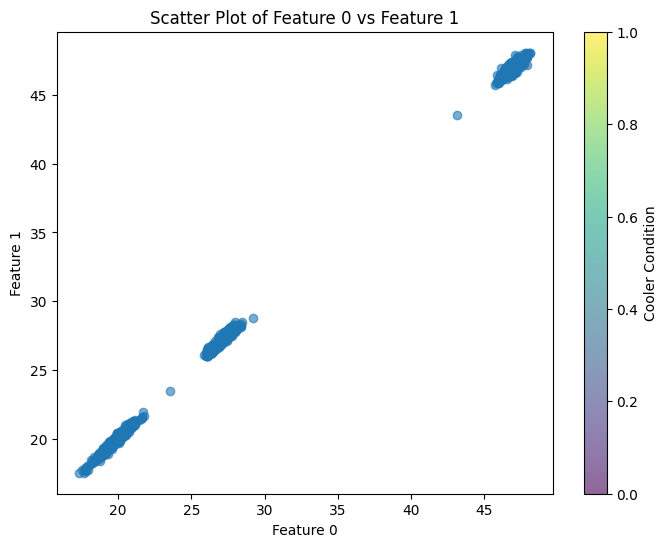

In [4]:
# Scatter plot of two features
plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], alpha=0.6, cmap='viridis')  # Use iloc for positional indexing
plt.colorbar(label='Cooler Condition')
plt.title('Scatter Plot of Feature 0 vs Feature 1')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()


In [5]:
# Check for missing values
print("Missing values in features:", df.isnull().sum().sum())
print("Missing values in target:", y.isnull().sum())

# Preprocessing
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


Missing values in features: 0
Missing values in target: 0


In [6]:
print("Shape of df_scaled:", df_scaled.shape)
print("Shape of y_encoded:", y_encoded.shape)


Shape of df_scaled: (2204, 43680)
Shape of y_encoded: (2205,)


In [7]:
print("Type of y_encoded:", type(y_encoded))



Type of y_encoded: <class 'numpy.ndarray'>


In [8]:
if not isinstance(y_encoded, pd.Series):
    y_encoded = pd.Series(y_encoded)  # Convert to pandas Series if it's not already


In [9]:
if df_scaled.shape[0] != y_encoded.shape[0]:
    y_encoded = y_encoded.iloc[:df_scaled.shape[0]]  # Align length of y_encoded with df_scaled

# Verify shapes after alignment
print("Aligned shape of df_scaled:", df_scaled.shape)
print("Aligned shape of y_encoded:", y_encoded.shape)


Aligned shape of df_scaled: (2204, 43680)
Aligned shape of y_encoded: (2204,)


In [10]:
print("Type of df_scaled:", type(df_scaled))
print("Type of y_encoded:", type(y_encoded))


Type of df_scaled: <class 'pandas.core.frame.DataFrame'>
Type of y_encoded: <class 'pandas.core.series.Series'>


In [11]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_encoded, test_size=0.2, random_state=42)

# Ensure that the data is properly split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (1763, 43680), X_test shape: (441, 43680)
y_train shape: (1763,), y_test shape: (441,)


In [12]:
# Ensure that X_train and y_train are NumPy arrays
X_train = np.nan_to_num(X_train, nan=0)  # Replace NaNs in X_train with 0
y_train = np.nan_to_num(y_train, nan=0)  # Replace NaNs in y_train with 0

# Ensure X_test is also a NumPy array
X_test = X_test.to_numpy()  # Convert X_test to NumPy array if it's a DataFrame

# Initialize the XGBoost model
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Check predictions
print("Predictions:", y_pred)

c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predictions: [1 0 2 1 2 0 1 0 0 1 1 1 0 2 1 2 2 1 0 2 1 0 1 0 0 0 2 2 1 0 1 0 2 2 0 2 2
 2 1 0 2 2 0 0 2 1 2 2 2 2 1 2 0 2 2 1 2 0 1 1 1 2 2 0 0 0 0 2 2 2 2 2 0 0
 2 1 1 1 0 2 2 2 0 0 0 1 2 2 2 1 2 2 2 0 0 0 0 1 1 2 1 0 2 0 0 2 2 2 2 2 0
 2 1 0 0 1 2 2 0 2 0 0 0 1 1 0 0 2 2 1 1 1 2 2 0 1 1 0 1 0 0 0 2 1 0 2 0 0
 2 2 0 1 1 2 2 2 2 1 0 0 1 1 1 1 1 0 1 1 2 0 2 0 1 0 0 1 2 2 1 2 1 0 0 2 2
 0 0 2 1 0 0 0 1 2 1 1 2 0 2 2 2 2 1 2 1 0 0 0 0 1 2 0 2 0 0 2 0 0 2 0 2 0
 0 1 1 2 2 1 1 0 0 0 1 2 1 1 2 1 1 0 0 1 0 2 0 2 2 1 1 1 1 2 0 0 0 1 0 0 0
 2 2 0 2 0 0 0 0 0 0 0 0 1 1 2 2 0 2 0 0 1 0 0 2 2 1 1 1 2 2 2 0 2 1 2 0 2
 2 2 2 0 1 1 0 2 0 0 0 0 0 2 2 1 0 2 0 1 2 0 2 0 2 1 2 1 0 1 0 1 0 2 2 1 1
 0 1 2 1 1 0 2 2 1 0 2 1 1 2 0 2 0 1 0 1 0 0 2 2 1 1 1 0 0 1 1 1 2 0 2 1 2
 1 1 1 1 2 0 1 1 2 1 1 0 0 0 1 2 2 2 2 2 0 2 0 2 1 2 2 2 2 2 0 2 1 0 2 2 1
 0 1 2 2 0 2 1 1 0 0 1 1 1 2 0 2 0 0 2 2 2 0 0 0 1 1 2 0 2 0 0 0 0 1]


In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       127
           2       1.00      1.00      1.00       157

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



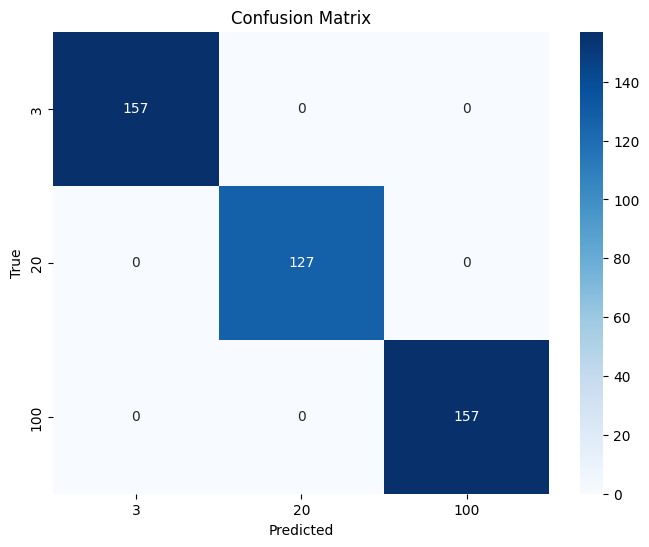

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Check accuracy on training data
train_accuracy = xgb.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 1.0


In [16]:
# Convert DataFrame to NumPy arrays
X = df_scaled.to_numpy()  # Features as NumPy array
y = y_encoded.to_numpy()  # Labels as NumPy array


from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
scores = cross_val_score(xgb, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-validation scores: [0.93197279 1.         1.         1.         0.99772727]
Mean cross-validation score: 0.9859400123685838


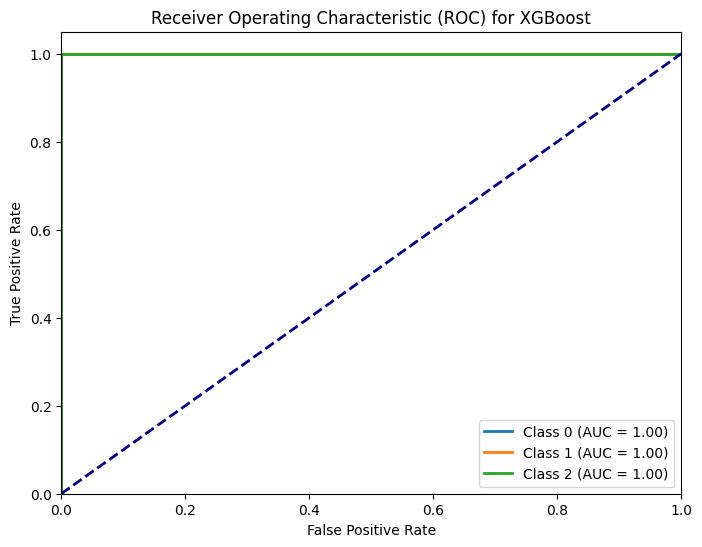

AUC for class 0: 1.00
AUC for class 1: 1.00
AUC for class 2: 1.00


In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Get the predicted probabilities for each class (multi-class classification)
y_prob = xgb.predict_proba(X_test)

# Binarize the true labels for multi-class AUC calculation
lb = LabelBinarizer()
y_bin = lb.fit_transform(y_test)

# Initialize dictionaries for storing ROC data
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve and AUC for each class
for i in range(y_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(8, 6))
for i in range(y_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for XGBoost')
plt.legend(loc="lower right")
plt.show()

# Print AUC for each class
for i in range(y_bin.shape[1]):
    print(f'AUC for class {lb.classes_[i]}: {roc_auc[i]:.2f}')



In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, log_loss
import numpy as np


# y_test: The actual test labels (ground truth)
# y_pred: The predicted labels by your classifier
# y_prob: The predicted probabilities (for log loss calculation and AUC)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro', 'micro', or 'weighted' for multi-class
print("Precision: ", precision)

# Recall (Sensitivity or True Positive Rate)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall (Sensitivity): ", recall)

# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score: ", f1)


# Specificity (True Negative Rate) for multi-class classification
# For each class, calculate the specificity:
specificities = []
for i in range(cm.shape[0]):
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]  # True Negatives
    fp = np.sum(cm[:, i]) - cm[i, i]  # False Positives
    specificity = tn / (tn + fp) if tn + fp != 0 else 0  # Avoid division by zero
    specificities.append(specificity)
    print(f"Specificity for Class {i}: {specificity}")



# Log Loss (Only for models that output probabilities, not class labels)
log_loss_value = log_loss(y_test, y_prob)
print("Log Loss: ", log_loss_value)



Confusion Matrix:
 [[157   0   0]
 [  0 127   0]
 [  0   0 157]]
Precision:  1.0
Recall (Sensitivity):  1.0
F1-Score:  1.0
Specificity for Class 0: 1.0
Specificity for Class 1: 1.0
Specificity for Class 2: 1.0
Log Loss:  0.000906921336010927


c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

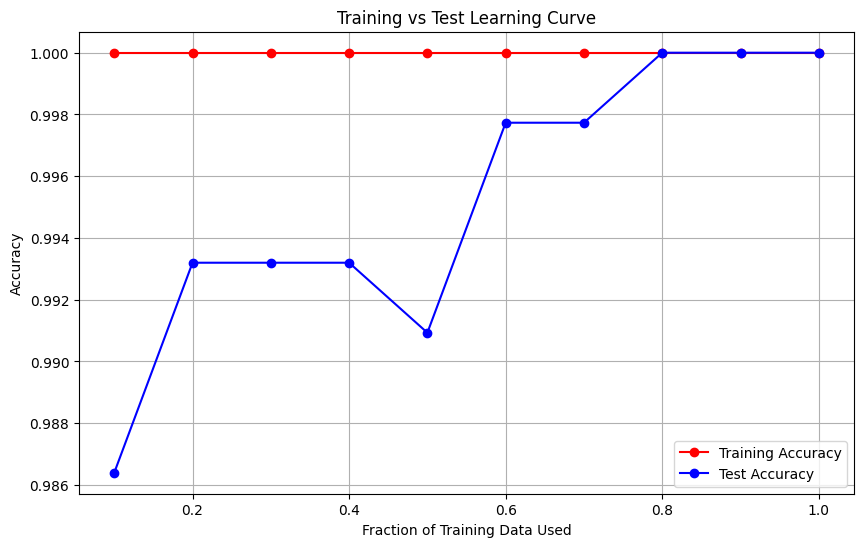

In [21]:
# # Function to plot learning curve for train vs test
# def plot_train_vs_test_curve(estimator, X_train, y_train, X_test, y_test, train_sizes=np.linspace(0.1, 1.0, 10)):
#     train_scores = []
#     test_scores = []

#     # Loop through different training set sizes
#     for train_size in train_sizes:
#         # Calculate number of samples
#         X_train_partial = X_train[:int(len(X_train) * train_size)]
#         y_train_partial = y_train[:int(len(y_train) * train_size)]

#         # Fit the model on the partial training set
#         estimator.fit(X_train_partial, y_train_partial)

#         # Evaluate on the partial training set
#         y_train_pred = estimator.predict(X_train_partial)
#         train_accuracy = accuracy_score(y_train_partial, y_train_pred)

#         # Evaluate on the test set
#         y_test_pred = estimator.predict(X_test)
#         test_accuracy = accuracy_score(y_test, y_test_pred)

#         # Store scores
#         train_scores.append(train_accuracy)
#         test_scores.append(test_accuracy)

#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training Accuracy")
#     plt.plot(train_sizes, test_scores, 'o-', color="b", label="Test Accuracy")
#     plt.title("Training vs Test Learning Curve")
#     plt.xlabel("Fraction of Training Data Used")
#     plt.ylabel("Accuracy")
#     plt.grid()
#     plt.legend(loc="best")
#     plt.show()

# # Plot the learning curve for XGBoost
# plot_train_vs_test_curve(xgb, X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())






















# Function to plot learning curve for train vs test
from sklearn.metrics import accuracy_score

def plot_train_vs_test_curve(estimator, X_train, y_train, X_test, y_test, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores = []
    test_scores = []

    # Loop through different training set sizes
    for train_size in train_sizes:
        # Calculate number of samples
        X_train_partial = X_train[:int(len(X_train) * train_size)]
        y_train_partial = y_train[:int(len(y_train) * train_size)]

        # Fit the model on the partial training set
        estimator.fit(X_train_partial, y_train_partial)

        # Evaluate on the partial training set
        y_train_pred = estimator.predict(X_train_partial)
        train_accuracy = accuracy_score(y_train_partial, y_train_pred)

        # Evaluate on the test set
        y_test_pred = estimator.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Store scores
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, test_scores, 'o-', color="b", label="Test Accuracy")
    plt.title("Training vs Test Learning Curve")
    plt.xlabel("Fraction of Training Data Used")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

# Plot the learning curve for XGBoost
plot_train_vs_test_curve(xgb, X_train, y_train, X_test, y_test)

